# Remote-jobs-analytics


In [13]:

import os
import json
import pandas as pd
import psycopg2
import requests
from dotenv import load_dotenv


In [14]:

try:
    import pandas
    import psycopg2
    import dotenv
    print("All required packages are installed.")
except ImportError as e:
    print(f"Missing package: {e.name}")


All required packages are installed.


In [15]:
load_dotenv() ## Load environment variables from a .env file

True

In [16]:
API_KEY = os.getenv("API_KEY")
API_HOST=os.getenv("API_HOST")
COUNTRY = 'us'
EMPLOYMENT_TYPE= 'fulltime'

In [17]:
url ="https://remote-jobs1.p.rapidapi.com/jobs"
headers =  {
	"x-rapidapi-key": API_KEY,
	"x-rapidapi-host": API_HOST
    
}
querystring = {"country":COUNTRY,
               "employmentType": EMPLOYMENT_TYPE}

In [18]:
print(querystring)

{'country': 'us', 'employmentType': 'fulltime'}


---------------- EXTRACTION ---------------

In [19]:
response = requests.get(url=url,
                        headers=headers,
                          params=querystring)


In [20]:
payload = response.json()


In [21]:
print(payload)

[{'id': 170871761, 'slug': 'web-developer-ecrm', 'url': 'https://apply.workable.com/j/68F0DF295B', 'title': 'Web Developer, eCRM', 'description': '<p>This position is posted by Jobgether on behalf of a partner company. We are currently looking for a <strong>Web Developer, eCRM</strong> in the <strong>United States</strong>.</p><p>As a Web Developer, eCRM, you will play a pivotal role in supporting digital initiatives by building and maintaining custom web solutions that enhance user engagement, fundraising, and advocacy efforts. You will collaborate closely with cross-functional teams, ensuring web projects meet technical, security, and compliance standards while delivering seamless user experiences. This role emphasizes both front-end development expertise and strategic problem-solving to optimize websites and forms for global audiences. You will contribute to testing, documentation, and the integration of innovative digital tools, helping the organization achieve measurable impact th

In [22]:
# Debug cell — inspect response and payload structure safely
from pprint import pprint
import json

# show HTTP status (helps diagnose subscription/auth errors)
print("HTTP status:", getattr(response, "status_code", None))

# show type so you know why payload["response"] failed
print("payload type:", type(payload))

if isinstance(payload, list):
    print("payload is a list, length =", len(payload))
    if payload:
        print("first element type:", type(payload[0]))
        if isinstance(payload[0], dict):
            print("first element keys:")
            pprint(list(payload[0].keys()))
            if "response" in payload[0]:
                print("\npayload[0]['response'] preview:")
                pprint(payload[0]["response"])
        else:
            print("\nfirst element preview:")
            pprint(payload[0])
elif isinstance(payload, dict):
    print("payload is a dict; top-level keys:")
    pprint(list(payload.keys()))
    if "response" in payload:
        print("\npayload['response'] preview:")
        pprint(payload["response"])
else:
    print("payload preview:")
    pprint(payload)

# save raw payload for offline inspection
with open("payload.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)
print("Saved payload.json")

HTTP status: 206
payload type: <class 'list'>
payload is a list, length = 100
first element type: <class 'dict'>
first element keys:
['id',
 'slug',
 'url',
 'title',
 'description',
 'datePosted',
 'dateDeleted',
 'skills',
 'categories',
 'employmentTypes',
 'locationTypes',
 'countries',
 'company']
Saved payload.json


In [23]:
# Extraction cell — normalize whatever structure we have into a list of records and a DataFrame
import pandas as pd

records = []

# If payload is a list, each item is likely a record
if isinstance(payload, list):
    for item in payload:
        if isinstance(item, dict):
            records.append(item)
        else:
            # wrap primitives so they still become rows
            records.append({"value": item})

# If payload is a dict, common patterns store results under 'data' or 'response'
elif isinstance(payload, dict):
    if "data" in payload and isinstance(payload["data"], list):
        records = payload["data"]
    elif "response" in payload and isinstance(payload["response"], list):
        records = payload["response"]
    else:
        # fallback: treat the whole dict as one record
        records = [payload]

else:
    # non-list/dict payload -> single record
    records = [{"payload": payload}]

print("Extracted records count:", len(records))

# Try to convert to DataFrame and save
try:
    df = pd.json_normalize(records)
    print("DataFrame shape:", df.shape)
    display(df.head())
    df.to_csv("remote_jobs.csv", index=False)
    print("Saved remote_jobs.csv")
except Exception as e:
    print("Could not convert to DataFrame:", e)
    from pprint import pprint
    pprint(records[:5])

Extracted records count: 100
DataFrame shape: (100, 24)


,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
0,170871761,web-developer-ecrm,https://apply.workable.com/j/68F0DF295B,"Web Developer, eCRM",<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,None,"[aws, github, html5, javascript, npm, sass]",None,[fulltime],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020,Find your dream remote job,Internet Marketplace Platforms,"[Avenue Louise, Brussels, Brussels Region, BE]","Your future of work, like you've always dreamt...",None
1,170871760,staff-principal-software-engineer-backend,https://apply.workable.com/j/65167D0EA1,Staff/Principal Software Engineer (Backend),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,None,"[aws, cicd, devops, kubernetes, mongodb, nodej...","[engineering, software-development, back-end]",[fulltime],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020,Find your dream remote job,Internet Marketplace Platforms,"[Avenue Louise, Brussels, Brussels Region, BE]","Your future of work, like you've always dreamt...",None
2,170871759,staff-software-engineer-remote-us-170871759,https://apply.workable.com/j/3F597782C5,Staff Software Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,None,"[apache, aws, cicd, dynamodb, mysql, nosql, po...","[engineering, software-development]",[fulltime],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020,Find your dream remote job,Internet Marketplace Platforms,"[Avenue Louise, Brussels, Brussels Region, BE]","Your future of work, like you've always dreamt...",None
3,170871758,staff-frontend-engineer-remote-us-170871758,https://apply.workable.com/j/64CEE1FC89,Staff Frontend Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,None,"[graphql, javascript, mobx, react, redux, type...","[engineering, front-end, software-development]",[fulltime],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020,Find your dream remote job,Internet Marketplace Platforms,"[Avenue Louise, Brussels, Brussels Region, BE]","Your future of work, like you've always dreamt...",None
4,170871757,staff-front-end-engineer-remote-us-170871757,https://apply.workable.com/j/AA50843C05,Staff Front End Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,None,"[bitbucket, cicd, github, jest, react, redux, ...","[engineering, front-end, software-development]",[fulltime],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020,Find your dream remote job,Internet Marketplace Platforms,"[Avenue Louise, Brussels, Brussels Region, BE]","Your future of work, like you've always dreamt...",None


Saved remote_jobs.csv


In [24]:
remote_jobs=df.copy()

#copy for EDA/cleaning

In [25]:
remote_jobs_raw=df.copy()

In [26]:
remote_jobs_raw.to_csv('remote_jobs_raw.csv',index=False)

In [27]:
print(f"Backup saved -> remote_jobs_raw.csv")

Backup saved -> remote_jobs_raw.csv


In [28]:
df= pd.read_csv("remote_jobs.csv")
df

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
0,170871761,web-developer-ecrm,https://apply.workable.com/j/68F0DF295B,"Web Developer, eCRM",<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['aws', 'github', 'html5', 'javascript', 'npm'...",NaN,['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
1,170871760,staff-principal-software-engineer-backend,https://apply.workable.com/j/65167D0EA1,Staff/Principal Software Engineer (Backend),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['aws', 'cicd', 'devops', 'kubernetes', 'mongo...","['engineering', 'software-development', 'back-...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
2,170871759,staff-software-engineer-remote-us-170871759,https://apply.workable.com/j/3F597782C5,Staff Software Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['apache', 'aws', 'cicd', 'dynamodb', 'mysql',...","['engineering', 'software-development']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
3,170871758,staff-frontend-engineer-remote-us-170871758,https://apply.workable.com/j/64CEE1FC89,Staff Frontend Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['graphql', 'javascript', 'mobx', 'react', 're...","['engineering', 'front-end', 'software-develop...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
4,170871757,staff-front-end-engineer-remote-us-170871757,https://apply.workable.com/j/AA50843C05,Staff Front End Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['bitbucket', 'cicd', 'github', 'jest', 'react...","['engineering', 'front-end', 'software-develop...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,170798988,head-of-marketing-170798988,https://jobs.ashbyhq.com/thewfsgroup/423b3896-...,Head of Marketing,<h1><strong>Head of Marketing (aka The Growth ...,2025-10-04T03:00:56.237+00:00,NaN,NaN,['marketing'],['fulltime'],...,https://thewfsgroup.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,170798987,revenue-operations-lead-170798987,https://jobs.ashbyhq.com/wander/8e693fba-caa6-...,Revenue Operations Lead,<h1><strong>Revenue Operations Leader</strong>...,2025-10-04T00:33:36.444+00:00,NaN,NaN,['operations'],['fulltime'],...,NaN,https://www.linkedin.com/company/wander,201-500,Privately Held,NaN,NaN,"Movies, Videos, and Sound","['', '']",NaN,NaN
97,170798981,business-operations-senior-anal

--------- EDA --------

Inspecting structure

In [29]:
print(f" The table has {df.shape[0]} row and {df.shape[1]} columns")


 The table has 100 row and 24 columns


In [30]:
df.head(10)

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
0,170871761,web-developer-ecrm,https://apply.workable.com/j/68F0DF295B,"Web Developer, eCRM",<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['aws', 'github', 'html5', 'javascript', 'npm'...",NaN,['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
1,170871760,staff-principal-software-engineer-backend,https://apply.workable.com/j/65167D0EA1,Staff/Principal Software Engineer (Backend),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['aws', 'cicd', 'devops', 'kubernetes', 'mongo...","['engineering', 'software-development', 'back-...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
2,170871759,staff-software-engineer-remote-us-170871759,https://apply.workable.com/j/3F597782C5,Staff Software Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['apache', 'aws', 'cicd', 'dynamodb', 'mysql',...","['engineering', 'software-development']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
3,170871758,staff-frontend-engineer-remote-us-170871758,https://apply.workable.com/j/64CEE1FC89,Staff Frontend Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['graphql', 'javascript', 'mobx', 'react', 're...","['engineering', 'front-end', 'software-develop...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
4,170871757,staff-front-end-engineer-remote-us-170871757,https://apply.workable.com/j/AA50843C05,Staff Front End Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['bitbucket', 'cicd', 'github', 'jest', 'react...","['engineering', 'front-end', 'software-develop...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
5,170871756,sourcing-manager-remote,https://apply.workable.com/j/A440EEE979,Sourcing Manager (Remote),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,NaN,NaN,['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
6,170871755,solutions-architect-javascript-remote-us,https://apply.workable.com/j/B0DEDBE497,Solutions Architect - JavaScript (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,"['javascript', 'aws', 'azure', 'gcp', 'nodejs'...",NaN,['fulltime'],...,https://www.jobgether

In [31]:
df.tail(10)

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
90,170803427,fullstack-developer-agentic-ai-170803427,https://apply.workable.com/j/937A282985,Fullstack Developer (Agentic AI),<p><strong>This position is posted by Jobgethe...,2025-10-04T00:00:00+00:00,NaN,"['aws', 'cicd', 'devops', 'docker', 'java', 'j...","['full-stack', 'ai', 'software-development', '...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
91,170803426,electrical-field-engineer-remote-us,https://apply.workable.com/j/BEF6A76AC2,Electrical Field Engineer (Remote - US),<p><strong>This position is posted by Jobgethe...,2025-10-04T00:00:00+00:00,NaN,NaN,['engineering'],['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
92,170803425,data-engineer-manager-remote-us,https://apply.workable.com/j/414B941E49,Data Engineer Manager (Remote - US),<p><strong>This position is posted by Jobgethe...,2025-10-04T00:00:00+00:00,NaN,"['git', 'python']","['engineering', 'data', 'data-engineer']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
93,170803423,configuration-engineer-remote-us,https://apply.workable.com/j/C96183D183,Configuration Engineer (Remote - US),<p><strong>This position is posted by Jobgethe...,2025-10-04T00:00:00+00:00,NaN,"['cicd', 'devops', 'docker', 'git', 'javascrip...",['engineering'],['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
94,170802300,customer-marketing-manager-170802300,https://jobs.lever.co/owner/03782476-102c-418d...,Customer Marketing Manager,<div>We’re scaling our Customer Marketing func...,2025-10-04T01:27:08+00:00,NaN,NaN,"['marketing', 'support']",['fulltime'],...,https://owner.com,https://www.linkedin.com/company/owner-com,51-200,Privately Held,2018.0,All-in-one digital presence for restaurants. P...,Software Development,"['San Francisco, CA 94129, US']",Owner is the all-in-one platform for managing ...,NaN
95,170798988,head-of-marketing-170798988,https://jobs.ashbyhq.com/thewfsgroup/423b3896-...,Head of Marketing,<h1><strong>Head of Marketing (aka The Growth ...,2025-10-04T03:00:56.237+00:00,NaN,NaN,['marketing'],['fulltime'],...,https://thewfsgroup.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,170798987,revenue-operations-lead-170798987,https://jobs.ashbyhq.com/wander/8e693fba-caa6-...,Revenue Operations Lead,<h1><strong>Revenue Operations Leader</strong>...,2025-10-04T00:33:36.444+00:00,NaN,NaN,['operations'],['fulltime'],...,NaN,https://www.linkedin.com/company/wander,201-500,Privately Held,NaN,NaN,"Movies, Videos, and Sound","['', '']",NaN,NaN
97,170798981,business-operations-senior-analyst-170798981,https://jobs.ashbyhq.com/speak/761fade9-9ec0-4...,Business Operations Senior Analyst,"<h1><strong>About us</strong></h1><p style=""mi...",2025-10-04T03:29:57.938+00:00,NaN,NaN,"['business', 'operations']",['fulltime'],...,https://www.speak.com/,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [32]:
df.columns.tolist()

['id',
 'slug',
 'url',
 'title',
 'description',
 'datePosted',
 'dateDeleted',
 'skills',
 'categories',
 'employmentTypes',
 'locationTypes',
 'countries',
 'company.name',
 'company.slug',
 'company.website',
 'company.linkedinUrl',
 'company.linkedinSize',
 'company.linkedinType',
 'company.linkedinFounded',
 'company.linkedinTagline',
 'company.linkedinIndustry',
 'company.linkedinLocations',
 'company.linkedinDescription',
 'company.linkedinSpecialties']

In [33]:
df.dtypes

id                               int64
slug                            object
url                             object
title                           object
description                     object
datePosted                      object
dateDeleted                    float64
skills                          object
categories                      object
employmentTypes                 object
locationTypes                   object
countries                       object
company.name                    object
company.slug                    object
company.website                 object
company.linkedinUrl             object
company.linkedinSize            object
company.linkedinType            object
company.linkedinFounded        float64
company.linkedinTagline         object
company.linkedinIndustry        object
company.linkedinLocations       object
company.linkedinDescription     object
company.linkedinSpecialties     object
dtype: object

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           100 non-null    int64  
 1   slug                         100 non-null    object 
 2   url                          100 non-null    object 
 3   title                        100 non-null    object 
 4   description                  100 non-null    object 
 5   datePosted                   100 non-null    object 
 6   dateDeleted                  0 non-null      float64
 7   skills                       47 non-null     object 
 8   categories                   83 non-null     object 
 9   employmentTypes              100 non-null    object 
 10  locationTypes                100 non-null    object 
 11  countries                    100 non-null    object 
 12  company.name                 100 non-null    object 
 13  company.slug         

summary statistics

In [35]:
df.describe()

,id,dateDeleted,company.linkedinFounded
count,1.000000e+02,0.0,88.000000
mean,1.708486e+08,NaN,2017.125000
std,3.096412e+04,NaN,5.543584
min,1.707988e+08,NaN,1996.000000
25%,1.708034e+08,NaN,2017.500000
50%,1.708715e+08,NaN,2020.000000
75%,1.708717e+08,NaN,2020.000000
max,1.708718e+08,NaN,2022.000000


In [36]:
df.describe(include='all')

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
count,1.000000e+02,100,100,100,100,100,0.0,47,83,100,...,97,93,93,93,88.000000,88,93,93,92,24
unique,NaN,100,100,98,100,36,NaN,35,40,2,...,14,10,4,2,NaN,8,8,10,9,5
top,NaN,web-developer-ecrm,https://apply.workable.com/j/68F0DF295B,Software Engineer in Test (Remote),<p>This position is posted by Jobgether on beh...,2025-10-06T00:00:00+00:00,NaN,['jira'],['engineering'],['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,NaN,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...","['Financial services innovation', 'Financially..."
freq,NaN,1,1,3,1,40,NaN,6,7,98,...,63,63,67,90,NaN,63,63,63,63,16
mean,1.708486e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.125000,NaN,NaN,NaN,NaN,NaN
std,3.096412e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.543584,NaN,NaN,NaN,NaN,NaN
min,1.707988e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1996.000000,NaN,NaN,NaN,NaN,NaN
25%,1.708034e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.500000,NaN,NaN,NaN,NaN,NaN
50%,1.708715e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2020.000000,NaN,NaN,NaN,NaN,NaN
75%,1.708717e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2020.000000,NaN,NaN,NaN,NaN,NaN


In [37]:
cols_to_drop=[  "slug","url","dateDeleted",
    "company.slug","company.website","company.linkedinUrl",
    "company.linkedinSize","company.linkedinFounded",
    "company.linkedinTagline",
    "company.linkedinDescription","company.linkedinSpecialties","company.linkedinLocations"]

df.drop(columns=[c for c in cols_to_drop if c in df.columns],errors="ignore", inplace=True)
print("Dropped columns (if present).Remaining columns:",df.columns.tolist())

Dropped columns (if present).Remaining columns: ['id', 'title', 'description', 'datePosted', 'skills', 'categories', 'employmentTypes', 'locationTypes', 'countries', 'company.name', 'company.linkedinType', 'company.linkedinIndustry']


In [38]:
df.nunique()

id                          100
title                        98
description                 100
datePosted                   36
skills                       35
categories                   40
employmentTypes               2
locationTypes                 2
countries                     2
company.name                 16
company.linkedinType          2
company.linkedinIndustry      8
dtype: int64

missing values

In [39]:
df.duplicated().sum()

np.int64(0)

In [40]:
df['datePosted'] = pd.to_datetime(df['datePosted'], errors='coerce')

In [41]:
df.isna().sum().sort_values(ascending=False)

skills                      53
categories                  17
company.linkedinIndustry     7
company.linkedinType         7
datePosted                   6
description                  0
id                           0
title                        0
locationTypes                0
employmentTypes              0
company.name                 0
countries                    0
dtype: int64

In [42]:
cols_to_fill=['skills','datePosted','year','month','categories','company.linkedinType','company.linkedinLocations','company.linkedinIndustry']
for col in cols_to_fill:
    if col in df.columns:
        df[col].fillna('Unknown',inplace=True)
        print(f"Filled missing values in '{col}' with 'Unknown'")
    else:
        print(f"column '{col}' not found in dataframe")

Filled missing values in 'skills' with 'Unknown'
Filled missing values in 'datePosted' with 'Unknown'
column 'year' not found in dataframe
column 'month' not found in dataframe
Filled missing values in 'categories' with 'Unknown'
Filled missing values in 'company.linkedinType' with 'Unknown'
column 'company.linkedinLocations' not found in dataframe
Filled missing values in 'company.linkedinIndustry' with 'Unknown'


C:\Users\DELL\AppData\Local\Temp\ipykernel_1808\468856185.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown',inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_1808\468856185.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  df[col].fillna('Unknown',inplace=True)


In [43]:
df.isna().sum()

id                          0
title                       0
description                 0
datePosted                  0
skills                      0
categories                  0
employmentTypes             0
locationTypes               0
countries                   0
company.name                0
company.linkedinType        0
company.linkedinIndustry    0
dtype: int64

In [44]:
df.head(7)

,id,title,description,datePosted,skills,categories,employmentTypes,locationTypes,countries,company.name,company.linkedinType,company.linkedinIndustry
0,170871761,"Web Developer, eCRM",<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,"['aws', 'github', 'html5', 'javascript', 'npm'...",Unknown,['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms
1,170871760,Staff/Principal Software Engineer (Backend),<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,"['aws', 'cicd', 'devops', 'kubernetes', 'mongo...","['engineering', 'software-development', 'back-...",['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms
2,170871759,Staff Software Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,"['apache', 'aws', 'cicd', 'dynamodb', 'mysql',...","['engineering', 'software-development']",['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms
3,170871758,Staff Frontend Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,"['graphql', 'javascript', 'mobx', 'react', 're...","['engineering', 'front-end', 'software-develop...",['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms
4,170871757,Staff Front End Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,"['bitbucket', 'cicd', 'github', 'jest', 'react...","['engineering', 'front-end', 'software-develop...",['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms
5,170871756,Sourcing Manager (Remote),<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,Unknown,Unknown,['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms
6,170871755,Solutions Architect - JavaScript (Remote - US),<p>This position is posted by Jobgether on beh...,2025-10-06 00:00:00+00:00,"['javascript', 'aws', 'azure', 'gcp', 'nodejs'...",Unknown,['fulltime'],['remote'],['us'],Jobgether,Privately Held,Internet Marketplace Platforms


In [45]:
new_col_names=['company.name','company.linkedinType','company.linkedinIndustry']

for col in new_col_names:
    if col in df.columns:
        
        df[col].fillna('Unknown', inplace=True)
        print(f"Filled missing values in '{col}' with 'Unknown'")
    else:
        print(f"Column '{col}' not found in DataFrame")


Filled missing values in 'company.name' with 'Unknown'
Filled missing values in 'company.linkedinType' with 'Unknown'
Filled missing values in 'company.linkedinIndustry' with 'Unknown'


C:\Users\DELL\AppData\Local\Temp\ipykernel_1808\4111529328.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


In [46]:
df = df.rename(columns={
    'company.name': 'companyName',
    'company.linkedinType': 'companyType',
    'company.linkedinIndustry': 'Industry',

})


In [47]:
from bs4 import BeautifulSoup
df['description']= df['description'].apply(lambda x:BeautifulSoup(x,'html.parser').get_text() if isinstance(x,str) else x
)


In [48]:
import ast

cols = ['skills', 'categories', 'employmentTypes', 'locationTypes', 'countries']

df[cols] = df[cols].applymap(
    lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_1808\2650470218.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(


In [49]:
df.head(10)

,id,title,description,datePosted,skills,categories,employmentTypes,locationTypes,countries,companyName,companyType,Industry
0,170871761,"Web Developer, eCRM",This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"aws, github, html5, javascript, npm, sass",Unknown,fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
1,170871760,Staff/Principal Software Engineer (Backend),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"aws, cicd, devops, kubernetes, mongodb, nodejs...","engineering, software-development, back-end",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
2,170871759,Staff Software Engineer (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"apache, aws, cicd, dynamodb, mysql, nosql, pos...","engineering, software-development",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
3,170871758,Staff Frontend Engineer (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"graphql, javascript, mobx, react, redux, types...","engineering, front-end, software-development",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
4,170871757,Staff Front End Engineer (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"bitbucket, cicd, github, jest, react, redux, t...","engineering, front-end, software-development",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
5,170871756,Sourcing Manager (Remote),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,Unknown,Unknown,fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
6,170871755,Solutions Architect - JavaScript (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"javascript, aws, azure, gcp, nodejs, react",Unknown,fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
7,170871751,"Senior Security Engineer, Identity (Remote - US)",This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,Unknown,engineering,fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
8,170871750,"Senior Manager, Software Product Strategy (Rem...",This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,jira,product,fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
9,170871749,"Senior Data Scientist I, Analytics (Remote - US)",This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,python,"data, data-science",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms


In [50]:
df.columns.tolist()

['id',
 'title',
 'description',
 'datePosted',
 'skills',
 'categories',
 'employmentTypes',
 'locationTypes',
 'countries',
 'companyName',
 'companyType',
 'Industry']

In [51]:
cols_to_string=['title','description','skills', 'categories', 'employmentTypes', 'locationTypes', 'countries','companyName','companyType','Industry']

df[cols_to_string] = df[cols_to_string].astype('string')


In [52]:

df['datePosted'] = pd.to_datetime(df['datePosted'], errors='coerce')


In [53]:
df.dtypes

id                               int64
title                   string[python]
description             string[python]
datePosted         datetime64[ns, UTC]
skills                  string[python]
categories              string[python]
employmentTypes         string[python]
locationTypes           string[python]
countries               string[python]
companyName             string[python]
companyType             string[python]
Industry                string[python]
dtype: object

In [54]:
df.head(5)

,id,title,description,datePosted,skills,categories,employmentTypes,locationTypes,countries,companyName,companyType,Industry
0,170871761,"Web Developer, eCRM",This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"aws, github, html5, javascript, npm, sass",Unknown,fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
1,170871760,Staff/Principal Software Engineer (Backend),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"aws, cicd, devops, kubernetes, mongodb, nodejs...","engineering, software-development, back-end",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
2,170871759,Staff Software Engineer (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"apache, aws, cicd, dynamodb, mysql, nosql, pos...","engineering, software-development",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
3,170871758,Staff Frontend Engineer (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"graphql, javascript, mobx, react, redux, types...","engineering, front-end, software-development",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms
4,170871757,Staff Front End Engineer (Remote - US),This position is posted by Jobgether on behalf...,2025-10-06 00:00:00+00:00,"bitbucket, cicd, github, jest, react, redux, t...","engineering, front-end, software-development",fulltime,remote,us,Jobgether,Privately Held,Internet Marketplace Platforms


In [55]:
df['employmentTypes'].value_counts()

employmentTypes
fulltime              98
fulltime, contract     2
Name: count, dtype: Int64

In [56]:
df['locationTypes'].value_counts()

locationTypes
remote                    99
hybrid, remote, onsite     1
Name: count, dtype: Int64

In [57]:
df['countries'].value_counts()


countries
us        98
ca, us     2
Name: count, dtype: Int64

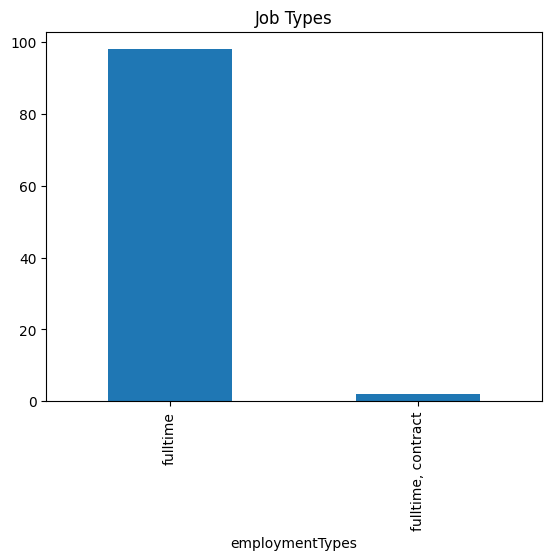

In [58]:
import matplotlib.pyplot as plt

df['employmentTypes'].value_counts().plot(kind='bar', title='Job Types')
plt.show()

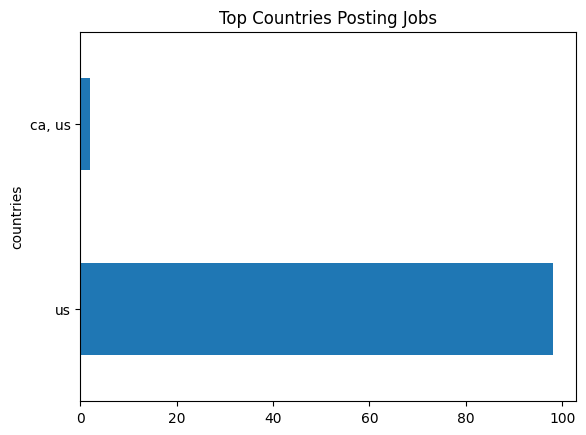

In [59]:
df['countries'].value_counts().head(10).plot(kind='barh', title='Top Countries Posting Jobs')
plt.show()

In [60]:
df.to_csv('remote_jobs_cleaned.csv', index=False)

In [61]:
from sqlalchemy import create_engine

dbname = os.getenv("POSTGRESQL_DB")
user = os.getenv("POSTGRESQL_USER")
password = os.getenv("POSTGRESQL_PASSWORD")
host = os.getenv("POSTGRESQL_HOST")
port = os.getenv("POSTGRESQL_PORT")



engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}")


df.to_sql("remote_jobs", engine, if_exists="replace", index=False)

print(" Data successfully loaded into PostgreSQL table 'remote_jobs'")

 Data successfully loaded into PostgreSQL table 'remote_jobs'
